# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [20]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [21]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


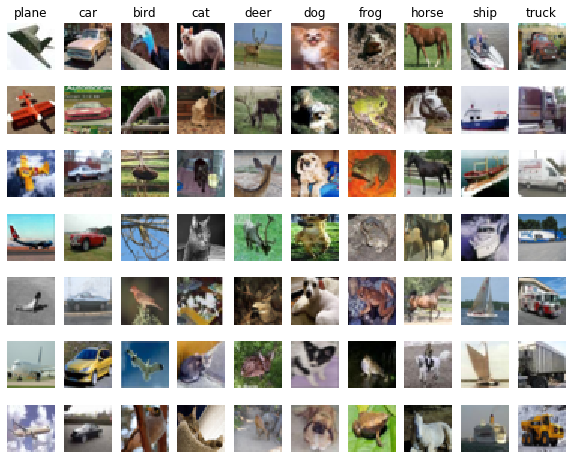

In [22]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [24]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


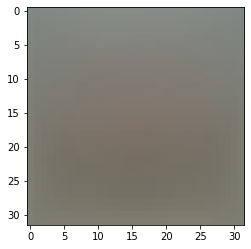

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [25]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [26]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.546404


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [27]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -32.160888 analytic: -32.160888, relative error: 2.810720e-12
numerical: -11.999112 analytic: -12.051813, relative error: 2.191213e-03
numerical: -13.672004 analytic: -13.613695, relative error: 2.137005e-03
numerical: 11.745331 analytic: 11.745331, relative error: 1.670379e-11
numerical: 19.257655 analytic: 19.257655, relative error: 1.140623e-11
numerical: 2.650770 analytic: 2.650770, relative error: 5.811991e-11
numerical: 4.527389 analytic: 4.527389, relative error: 4.247569e-12
numerical: 3.181667 analytic: 3.212519, relative error: 4.824991e-03
numerical: -4.881719 analytic: -4.881719, relative error: 2.722000e-11
numerical: 16.189617 analytic: 16.076720, relative error: 3.498911e-03
numerical: 28.720582 analytic: 28.605712, relative error: 2.003792e-03
numerical: -4.219291 analytic: -4.222123, relative error: 3.354321e-04
numerical: -3.825556 analytic: -3.825876, relative error: 4.178430e-05
numerical: 14.348929 analytic: 14.354739, relative error: 2.024180e-04
numeri

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ 
Due to the singularity introduced in the loss function, gradcheck will not match when the SVM takes a small area near zero. The simplest example is that if Δ=0, there is a high probability of getting near the singularity at the time of initialization.


In [28]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.546404e+00 computed in 0.389072s
Vectorized loss: 9.546404e+00 computed in 0.055285s
difference: 0.000000


In [29]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.282974s
Vectorized loss and gradient: computed in 0.041944s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [30]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 795.242879
iteration 100 / 1500: loss 474.617143
iteration 200 / 1500: loss 287.416993
iteration 300 / 1500: loss 175.677638
iteration 400 / 1500: loss 107.912150
iteration 500 / 1500: loss 66.821796
iteration 600 / 1500: loss 42.751690
iteration 700 / 1500: loss 28.158045
iteration 800 / 1500: loss 18.804689
iteration 900 / 1500: loss 13.611683
iteration 1000 / 1500: loss 10.231298
iteration 1100 / 1500: loss 9.025182
iteration 1200 / 1500: loss 7.074360
iteration 1300 / 1500: loss 6.610743
iteration 1400 / 1500: loss 6.203164
That took 38.284556s


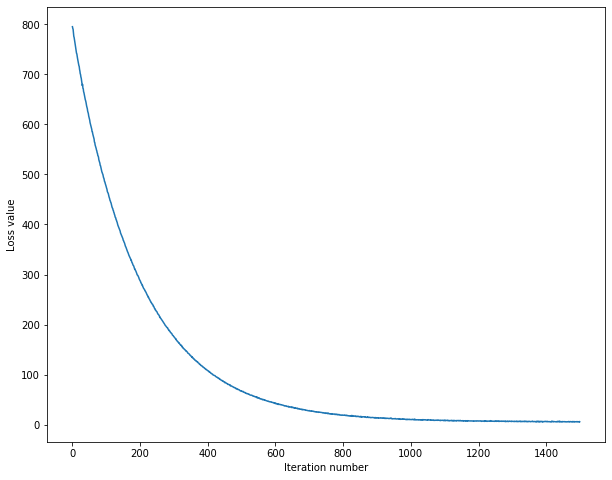

In [31]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383959
validation accuracy: 0.377000


In [35]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# learning_rates = [1e-7, 5e-5]
learning_rates = np.linspace(1e-7, 5e-7, 5)
# regularization_strengths = [2.5e4, 5e4]
regularization_strengths =np.linspace(2.5e4, 5e4, 6)


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should return the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

for rate in learning_rates:
    for reg_now in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=reg_now, num_iters=3000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(rate, reg_now)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 799.079480
iteration 100 / 3000: loss 475.535085
iteration 200 / 3000: loss 287.927079
iteration 300 / 3000: loss 175.535807
iteration 400 / 3000: loss 107.768906
iteration 500 / 3000: loss 66.959394
iteration 600 / 3000: loss 42.160702
iteration 700 / 3000: loss 28.062452
iteration 800 / 3000: loss 18.984861
iteration 900 / 3000: loss 13.670736
iteration 1000 / 3000: loss 10.294935
iteration 1100 / 3000: loss 8.304308
iteration 1200 / 3000: loss 7.049748
iteration 1300 / 3000: loss 6.514961
iteration 1400 / 3000: loss 5.597249
iteration 1500 / 3000: loss 5.779244
iteration 1600 / 3000: loss 5.484551
iteration 1700 / 3000: loss 5.856242
iteration 1800 / 3000: loss 5.187223
iteration 1900 / 3000: loss 5.783773
iteration 2000 / 3000: loss 5.600253
iteration 2100 / 3000: loss 5.505988
iteration 2200 / 3000: loss 5.825956
iteration 2300 / 3000: loss 5.689035
iteration 2400 / 3000: loss 5.358578
iteration 2500 / 3000: loss 4.862828
iteration 2600 / 3000: loss 5.0370

iteration 1200 / 3000: loss 5.729027
iteration 1300 / 3000: loss 6.183079
iteration 1400 / 3000: loss 5.873383
iteration 1500 / 3000: loss 5.879541
iteration 1600 / 3000: loss 5.366948
iteration 1700 / 3000: loss 5.497162
iteration 1800 / 3000: loss 5.828949
iteration 1900 / 3000: loss 5.877109
iteration 2000 / 3000: loss 5.600005
iteration 2100 / 3000: loss 5.393227
iteration 2200 / 3000: loss 5.884958
iteration 2300 / 3000: loss 5.165840
iteration 2400 / 3000: loss 5.312916
iteration 2500 / 3000: loss 5.564128
iteration 2600 / 3000: loss 5.099117
iteration 2700 / 3000: loss 5.902614
iteration 2800 / 3000: loss 5.534197
iteration 2900 / 3000: loss 5.457840
iteration 0 / 3000: loss 1119.015853
iteration 100 / 3000: loss 273.076977
iteration 200 / 3000: loss 69.944587
iteration 300 / 3000: loss 21.060069
iteration 400 / 3000: loss 9.351897
iteration 500 / 3000: loss 7.057963
iteration 600 / 3000: loss 5.951986
iteration 700 / 3000: loss 5.784607
iteration 800 / 3000: loss 5.918816
itera

iteration 2500 / 3000: loss 5.806262
iteration 2600 / 3000: loss 6.095157
iteration 2700 / 3000: loss 6.195635
iteration 2800 / 3000: loss 5.106946
iteration 2900 / 3000: loss 6.524236
iteration 0 / 3000: loss 1236.275169
iteration 100 / 3000: loss 112.206362
iteration 200 / 3000: loss 15.238604
iteration 300 / 3000: loss 6.509912
iteration 400 / 3000: loss 5.831414
iteration 500 / 3000: loss 5.573883
iteration 600 / 3000: loss 5.485702
iteration 700 / 3000: loss 5.445494
iteration 800 / 3000: loss 5.951305
iteration 900 / 3000: loss 5.563462
iteration 1000 / 3000: loss 5.813605
iteration 1100 / 3000: loss 6.237485
iteration 1200 / 3000: loss 6.245005
iteration 1300 / 3000: loss 5.509447
iteration 1400 / 3000: loss 6.492689
iteration 1500 / 3000: loss 5.805803
iteration 1600 / 3000: loss 5.411937
iteration 1700 / 3000: loss 5.603418
iteration 1800 / 3000: loss 5.989744
iteration 1900 / 3000: loss 5.671296
iteration 2000 / 3000: loss 5.335834
iteration 2100 / 3000: loss 5.326243
iterati

iteration 800 / 3000: loss 5.793357
iteration 900 / 3000: loss 6.031219
iteration 1000 / 3000: loss 6.303646
iteration 1100 / 3000: loss 6.183089
iteration 1200 / 3000: loss 5.693587
iteration 1300 / 3000: loss 5.948790
iteration 1400 / 3000: loss 6.364525
iteration 1500 / 3000: loss 6.054187
iteration 1600 / 3000: loss 6.049833
iteration 1700 / 3000: loss 5.656469
iteration 1800 / 3000: loss 5.934263
iteration 1900 / 3000: loss 6.460677
iteration 2000 / 3000: loss 5.004764
iteration 2100 / 3000: loss 5.485883
iteration 2200 / 3000: loss 5.801763
iteration 2300 / 3000: loss 6.182743
iteration 2400 / 3000: loss 5.828767
iteration 2500 / 3000: loss 5.863356
iteration 2600 / 3000: loss 5.880854
iteration 2700 / 3000: loss 5.916060
iteration 2800 / 3000: loss 6.285642
iteration 2900 / 3000: loss 6.118039
iteration 0 / 3000: loss 1571.473942
iteration 100 / 3000: loss 32.333249
iteration 200 / 3000: loss 7.226837
iteration 300 / 3000: loss 5.746796
iteration 400 / 3000: loss 6.349271
iterat

iteration 2200 / 3000: loss 6.533176
iteration 2300 / 3000: loss 5.990781
iteration 2400 / 3000: loss 5.903108
iteration 2500 / 3000: loss 6.213354
iteration 2600 / 3000: loss 6.606241
iteration 2700 / 3000: loss 6.788513
iteration 2800 / 3000: loss 6.233805
iteration 2900 / 3000: loss 6.360746
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.379755 val accuracy: 0.391000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.379551 val accuracy: 0.387000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.377592 val accuracy: 0.386000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.378102 val accuracy: 0.392000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.371898 val accuracy: 0.384000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.370878 val accuracy: 0.383000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.370061 val accuracy: 0.383000
lr 2.000000e-07 reg 3.000000e+04 train accuracy: 0.365408 val accuracy: 0.388000
lr 2.000000e-07 reg 3.500000e+04 train accuracy: 0.36257

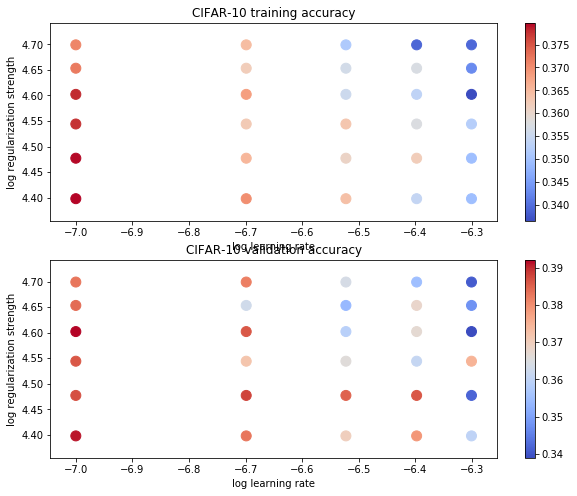

In [36]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [37]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.380000


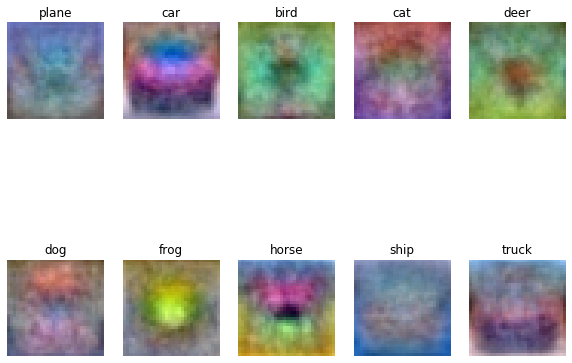

In [38]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$  
After the visualization of the SVM weights, the shadow of each category can be seen faintly because the SVM weights are equivalent to the characteristics of each category.